# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_power"],
    "x_transforms_target": ["unit_power"],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_power']
x_transforms_target ['unit_power']
Average magnitude, source: 0.8525984
Average power, source: 1.0


Average magnitude, target: 0.8961806
Average power, target: 1.0


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 1938.8770, train_label_loss: 4.7166, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3911.9851, train_label_loss: 4.0748, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4000.2679, train_label_loss: 3.4374, 


epoch: 1, [batch: 14 / 45], examples_per_second: 3998.4360, train_label_loss: 2.7074, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4019.4280, train_label_loss: 2.4061, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3962.9736, train_label_loss: 1.9656, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4069.9422, train_label_loss: 1.9441, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4072.8561, train_label_loss: 1.7045, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4104.8325, train_label_loss: 1.5564, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4153.5307, train_label_loss: 1.3564, 


epoch: 1, source_val_acc_label: 0.7987, target_val_acc_label: 0.7226, source_val_label_loss: 1.3384, target_val_label_loss: 1.5925, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 496.4920, train_label_loss: 1.2974, 


epoch: 2, [batch: 5 / 45], examples_per_second: 3982.2609, train_label_loss: 1.3825, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4083.7598, train_label_loss: 1.1852, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4077.9555, train_label_loss: 1.0691, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4087.4579, train_label_loss: 1.1142, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4034.3668, train_label_loss: 0.8100, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4140.9479, train_label_loss: 0.9019, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4135.1836, train_label_loss: 1.1830, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4168.6826, train_label_loss: 0.8450, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4230.6830, train_label_loss: 0.8144, 


epoch: 2, source_val_acc_label: 0.8532, target_val_acc_label: 0.7801, source_val_label_loss: 0.8942, target_val_label_loss: 1.2057, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 490.4692, train_label_loss: 0.7254, 


epoch: 3, [batch: 5 / 45], examples_per_second: 3984.6181, train_label_loss: 0.8514, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4075.8519, train_label_loss: 0.8693, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4088.4545, train_label_loss: 0.7663, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4096.4247, train_label_loss: 0.7403, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4037.7188, train_label_loss: 0.7561, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4141.9608, train_label_loss: 0.6693, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4138.2215, train_label_loss: 0.4963, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4177.6039, train_label_loss: 0.5480, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4237.1909, train_label_loss: 0.6238, 


epoch: 3, source_val_acc_label: 0.8885, target_val_acc_label: 0.8092, source_val_label_loss: 0.6775, target_val_label_loss: 1.0419, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 489.8790, train_label_loss: 0.4584, 


epoch: 4, [batch: 5 / 45], examples_per_second: 3971.3451, train_label_loss: 0.6746, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4077.6457, train_label_loss: 0.5697, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4083.6619, train_label_loss: 0.5981, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4095.5277, train_label_loss: 0.4743, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4025.8310, train_label_loss: 0.6366, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4118.5107, train_label_loss: 0.6245, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4130.8337, train_label_loss: 0.4337, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4173.4930, train_label_loss: 0.4605, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4232.3644, train_label_loss: 0.3462, 


epoch: 4, source_val_acc_label: 0.9064, target_val_acc_label: 0.8265, source_val_label_loss: 0.5274, target_val_label_loss: 0.9328, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 492.4220, train_label_loss: 0.3326, 


epoch: 5, [batch: 5 / 45], examples_per_second: 3980.0531, train_label_loss: 0.3906, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4085.8146, train_label_loss: 0.4698, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4092.6808, train_label_loss: 0.2461, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4091.7767, train_label_loss: 0.5252, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4031.5330, train_label_loss: 0.4167, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4131.0497, train_label_loss: 0.2923, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4136.4996, train_label_loss: 0.4047, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4179.4829, train_label_loss: 0.2658, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4231.6565, train_label_loss: 0.4162, 


epoch: 5, source_val_acc_label: 0.9192, target_val_acc_label: 0.8391, source_val_label_loss: 0.4508, target_val_label_loss: 0.8537, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 484.6548, train_label_loss: 0.3317, 


epoch: 6, [batch: 5 / 45], examples_per_second: 3973.9717, train_label_loss: 0.3255, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4074.8178, train_label_loss: 0.2699, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4083.9225, train_label_loss: 0.2917, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4066.3516, train_label_loss: 0.2340, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4020.3799, train_label_loss: 0.3486, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4121.2112, train_label_loss: 0.3737, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4130.7492, train_label_loss: 0.4236, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4163.0898, train_label_loss: 0.3522, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4222.6837, train_label_loss: 0.2236, 


epoch: 6, source_val_acc_label: 0.9359, target_val_acc_label: 0.8549, source_val_label_loss: 0.3796, target_val_label_loss: 0.8037, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 490.4083, train_label_loss: 0.3355, 


epoch: 7, [batch: 5 / 45], examples_per_second: 3989.8181, train_label_loss: 0.2783, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4071.9680, train_label_loss: 0.3409, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4084.4658, train_label_loss: 0.1451, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4080.0745, train_label_loss: 0.4133, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4013.4068, train_label_loss: 0.2924, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4123.0061, train_label_loss: 0.2280, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4131.8041, train_label_loss: 0.2422, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4167.4248, train_label_loss: 0.0966, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4217.5900, train_label_loss: 0.3090, 


epoch: 7, source_val_acc_label: 0.9442, target_val_acc_label: 0.8577, source_val_label_loss: 0.3510, target_val_label_loss: 0.7832, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 491.5887, train_label_loss: 0.1422, 


epoch: 8, [batch: 5 / 45], examples_per_second: 3970.8172, train_label_loss: 0.1631, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4082.4939, train_label_loss: 0.1976, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4075.7011, train_label_loss: 0.2686, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4071.3143, train_label_loss: 0.1933, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4015.9465, train_label_loss: 0.2688, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4129.7309, train_label_loss: 0.1923, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4125.8920, train_label_loss: 0.3311, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4169.4388, train_label_loss: 0.1452, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4222.1147, train_label_loss: 0.2292, 


epoch: 8, source_val_acc_label: 0.9481, target_val_acc_label: 0.8594, source_val_label_loss: 0.3420, target_val_label_loss: 0.7824, 


New best


epoch: 9, [batch: 1 / 45], examples_per_second: 486.5890, train_label_loss: 0.1793, 


epoch: 9, [batch: 5 / 45], examples_per_second: 3974.0369, train_label_loss: 0.1862, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4073.3734, train_label_loss: 0.2605, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4071.7421, train_label_loss: 0.1624, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4066.5199, train_label_loss: 0.2654, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4012.0590, train_label_loss: 0.1599, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4129.1555, train_label_loss: 0.2209, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4088.3957, train_label_loss: 0.2049, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4120.2261, train_label_loss: 0.1527, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4224.6173, train_label_loss: 0.1333, 


epoch: 9, source_val_acc_label: 0.9506, target_val_acc_label: 0.8647, source_val_label_loss: 0.3238, target_val_label_loss: 0.7680, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 489.5369, train_label_loss: 0.0944, 


epoch: 10, [batch: 5 / 45], examples_per_second: 3975.2103, train_label_loss: 0.1096, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4081.3556, train_label_loss: 0.1987, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4064.8407, train_label_loss: 0.1038, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4072.4896, train_label_loss: 0.2764, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4009.0501, train_label_loss: 0.0321, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4120.3251, train_label_loss: 0.2225, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4112.4256, train_label_loss: 0.1221, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4154.4861, train_label_loss: 0.3153, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4207.5399, train_label_loss: 0.0649, 


epoch: 10, source_val_acc_label: 0.9526, target_val_acc_label: 0.8613, source_val_label_loss: 0.3210, target_val_label_loss: 0.7370, 


epoch: 11, [batch: 1 / 45], examples_per_second: 500.4658, train_label_loss: 0.2113, 


epoch: 11, [batch: 5 / 45], examples_per_second: 3979.0017, train_label_loss: 0.1040, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4073.7157, train_label_loss: 0.2164, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4060.0415, train_label_loss: 0.2483, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4068.6424, train_label_loss: 0.1321, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4008.0941, train_label_loss: 0.0930, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4119.4349, train_label_loss: 0.1318, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4124.9478, train_label_loss: 0.0824, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4164.7255, train_label_loss: 0.0778, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4209.3118, train_label_loss: 0.1086, 


epoch: 11, source_val_acc_label: 0.9526, target_val_acc_label: 0.8624, source_val_label_loss: 0.3139, target_val_label_loss: 0.7502, 


epoch: 12, [batch: 1 / 45], examples_per_second: 501.9624, train_label_loss: 0.1006, 


epoch: 12, [batch: 5 / 45], examples_per_second: 3967.9681, train_label_loss: 0.2277, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4059.6592, train_label_loss: 0.1670, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4060.8326, train_label_loss: 0.1009, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4063.8649, train_label_loss: 0.0891, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4004.6723, train_label_loss: 0.1120, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4116.0205, train_label_loss: 0.2186, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4110.4771, train_label_loss: 0.1243, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4154.6495, train_label_loss: 0.2361, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4213.6056, train_label_loss: 0.1132, 


epoch: 12, source_val_acc_label: 0.9545, target_val_acc_label: 0.8694, source_val_label_loss: 0.3057, target_val_label_loss: 0.7094, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 486.6444, train_label_loss: 0.2206, 


epoch: 13, [batch: 5 / 45], examples_per_second: 3964.5593, train_label_loss: 0.1483, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4069.5823, train_label_loss: 0.1888, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4066.7798, train_label_loss: 0.1244, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4066.3667, train_label_loss: 0.0847, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4019.5109, train_label_loss: 0.1262, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4128.9475, train_label_loss: 0.0954, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4123.4099, train_label_loss: 0.1495, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4157.7706, train_label_loss: 0.1454, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4213.9231, train_label_loss: 0.1632, 


epoch: 13, source_val_acc_label: 0.9532, target_val_acc_label: 0.8624, source_val_label_loss: 0.2967, target_val_label_loss: 0.7300, 


epoch: 14, [batch: 1 / 45], examples_per_second: 502.0912, train_label_loss: 0.1220, 


epoch: 14, [batch: 5 / 45], examples_per_second: 3963.2885, train_label_loss: 0.0597, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4066.3288, train_label_loss: 0.1571, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4051.7750, train_label_loss: 0.1216, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4074.6336, train_label_loss: 0.1162, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4033.1934, train_label_loss: 0.1124, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4122.0804, train_label_loss: 0.1795, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4125.4924, train_label_loss: 0.0888, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4163.2818, train_label_loss: 0.0867, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4218.0516, train_label_loss: 0.0767, 


epoch: 14, source_val_acc_label: 0.9577, target_val_acc_label: 0.8694, source_val_label_loss: 0.3047, target_val_label_loss: 0.7239, 


epoch: 15, [batch: 1 / 45], examples_per_second: 502.4815, train_label_loss: 0.1342, 


epoch: 15, [batch: 5 / 45], examples_per_second: 3967.3156, train_label_loss: 0.1180, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4066.3698, train_label_loss: 0.0649, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4068.5519, train_label_loss: 0.0563, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4069.9756, train_label_loss: 0.1107, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4015.6626, train_label_loss: 0.1081, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4121.5242, train_label_loss: 0.0955, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4118.7876, train_label_loss: 0.0873, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4158.1143, train_label_loss: 0.1071, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4212.6078, train_label_loss: 0.1843, 


epoch: 15, source_val_acc_label: 0.9577, target_val_acc_label: 0.8690, source_val_label_loss: 0.2945, target_val_label_loss: 0.7125, 


epoch: 16, [batch: 1 / 45], examples_per_second: 502.1136, train_label_loss: 0.0924, 


epoch: 16, [batch: 5 / 45], examples_per_second: 3946.9273, train_label_loss: 0.1234, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4061.0409, train_label_loss: 0.0911, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4062.0354, train_label_loss: 0.1706, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4053.2961, train_label_loss: 0.1192, 


epoch: 16, [batch: 23 / 45], examples_per_second: 3997.2002, train_label_loss: 0.0837, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4102.2433, train_label_loss: 0.0565, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4107.6159, train_label_loss: 0.0594, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4150.8668, train_label_loss: 0.0665, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4213.1188, train_label_loss: 0.0370, 


epoch: 16, source_val_acc_label: 0.9596, target_val_acc_label: 0.8690, source_val_label_loss: 0.3117, target_val_label_loss: 0.7213, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

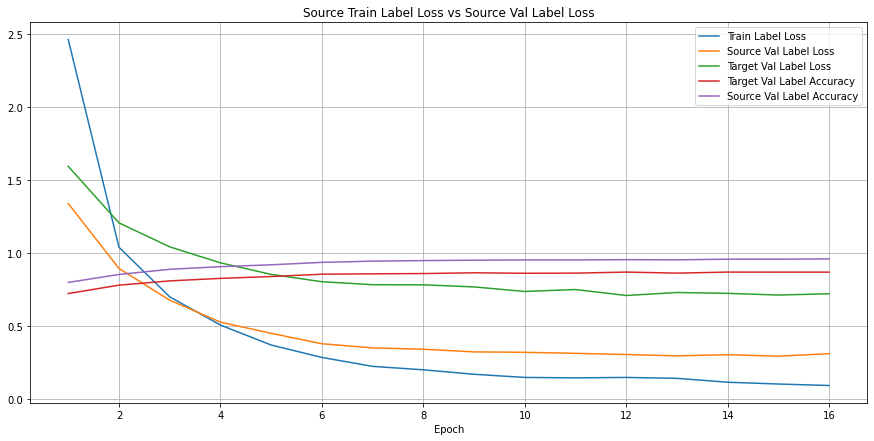

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

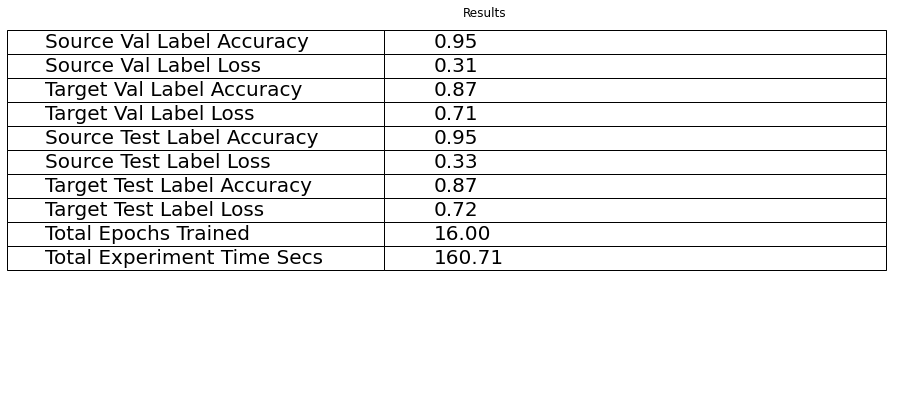

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

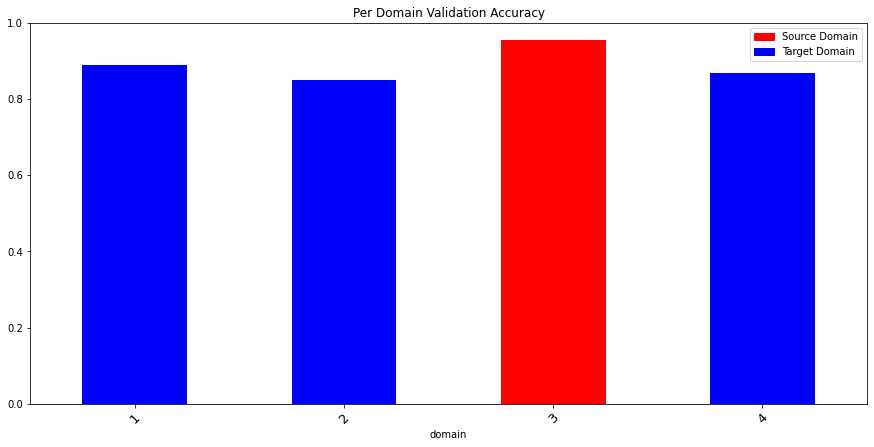

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9455128205128205 Target Test Label Accuracy: 0.8655982905982906
Source Val Label Accuracy: 0.9544871794871795 Target Val Label Accuracy: 0.8694444444444445


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "